<a href="https://colab.research.google.com/github/thisisSHAX/ML_Ops_Project-/blob/main/Development/Autism_Screening_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=16Pd-BdhzNMzPqPWD6XEu_XFZaGrSqFUz')

### Feature Set Selection

In [3]:
df.columns

Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits '],
      dtype='object')

In [4]:
x_columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Age_Mons','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']

In [5]:
cat_features = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']

In [6]:
num_features = list(set(x_columns) - set(cat_features))

### Encode Categorical Variables

In [7]:
encoded_df = pd.get_dummies(df[x_columns], columns=cat_features, drop_first = True)

In [8]:
x_features = list(encoded_df.columns)

In [9]:
x = encoded_df

In [10]:
x['Class/ASD Traits '] = df['Class/ASD Traits ']

### Data Splitting

In [11]:
X = encoded_df

In [12]:
Y = pd.get_dummies(df['Class/ASD Traits '], drop_first=True)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_prod, Y_train, Y_prod = train_test_split(X_train, Y_train, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

In [15]:
X_prod.shape

(211, 25)

### Finding the best model

In [16]:
# Installing H2O dependencies
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [17]:
# Installing H2O
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 32 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=7304549f727d4ecc9c5f9de964aba290144e4db9ed83192e963f456ee77eab49
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [18]:
import h2o
from h2o.automl import H2OAutoML

In [19]:
## prepare data
h2o.init()

h2o_train = h2o.H2OFrame(X_train)
h2o_test = h2o.H2OFrame(X_test)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1hw6phzr
  JVM stdout: /tmp/tmp1hw6phzr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1hw6phzr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_xyqbn3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
aml = H2OAutoML(max_models=10,
                seed=1,
                stopping_metric='MSE',
                sort_metric='MSE',
                max_runtime_secs = 300,
                exclude_algos = ["GLM", "DeepLearning"])

aml.train(x=x_features, 
          y='Class/ASD Traits ', 
          training_frame=h2o_train) 

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_1_20211125_100119

No model summary for this model

ModelMetricsBinomial: stackedensemble
** Reported on train data. **

MSE: 7.225134441777832e-05
RMSE: 0.008500079083030835
LogLoss: 0.004067977688077502
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9530239260241602: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,0.0,434.0,0.0,(0.0/434.0)
2,Total,198.0,434.0,0.0,(0.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.953024,1.000000,38.0
1,max f2,0.953024,1.000000,38.0
2,max f0point5,0.953024,1.000000,38.0
3,max accuracy,0.953024,1.000000,38.0
4,max precision,0.998256,1.000000,0.0
5,max recall,0.953024,1.000000,38.0
6,max specificity,0.998256,1.000000,0.0
7,max absolute_mcc,0.953024,1.000000,38.0
8,max min_per_class_accuracy,0.953024,1.000000,38.0
9,max mean_per_class_accuracy,0.953024,1.000000,38.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.018987,0.998031,1.456221,1.456221,1.000000,0.998059,1.000000,0.998059,0.027650,0.027650,45.622120,45.622120,0.027650
1,2,0.020570,0.997795,1.456221,1.456221,1.000000,0.997795,1.000000,0.998038,0.002304,0.029954,45.622120,45.622120,0.029954
2,3,0.030063,0.997779,1.456221,1.456221,1.000000,0.997785,1.000000,0.997958,0.013825,0.043779,45.622120,45.622120,0.043779
3,4,0.631329,0.997778,1.456221,1.456221,1.000000,0.997778,1.000000,0.997787,0.875576,0.919355,45.622120,45.622120,0.919355
4,5,0.699367,0.016433,1.185296,1.429864,0.813953,0.818770,0.981900,0.980371,0.080645,1.000000,18.529632,42.986425,0.959596
5,6,0.830696,0.004341,0.000000,1.203810,0.000000,0.006988,0.826667,0.826484,0.000000,1.000000,-100.000000,20.380952,0.540404
6,7,0.905063,0.004339,0.000000,1.104895,0.000000,0.004339,0.758741,0.758930,0.000000,1.000000,-100.000000,10.489510,0.303030
7,8,1.000000,0.004250,0.000000,1.000000,0.000000,0.004326,0.686709,0.687291,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: stackedensemble
** Reported on cross-validation data. **

MSE: 0.011230029336156098
RMSE: 0.10597183274887766
LogLoss: 0.046157601805581594
Mean Per-Class Error: 0.00691244239631339
AUC: 0.9976376669925057
AUCPR: 0.9990452157739768
Gini: 0.9952753339850113

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6607768910857049: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,6.0,428.0,0.0138,(6.0/434.0)
2,Total,204.0,428.0,0.0095,(6.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.660777,0.993039,78.0
1,max f2,0.233229,0.989416,87.0
2,max f0point5,0.660777,0.997204,78.0
3,max accuracy,0.660777,0.990506,78.0
4,max precision,0.998359,1.000000,0.0
5,max recall,0.004451,1.000000,169.0
6,max specificity,0.998359,1.000000,0.0
7,max absolute_mcc,0.660777,0.978351,78.0
8,max min_per_class_accuracy,0.660777,0.986175,78.0
9,max mean_per_class_accuracy,0.660777,0.993088,78.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011076,0.998049,1.456221,1.456221,1.000000,0.998206,1.000000,0.998206,0.016129,0.016129,45.622120,45.622120,0.016129
1,2,0.020570,0.997979,1.456221,1.456221,1.000000,0.998001,1.000000,0.998111,0.013825,0.029954,45.622120,45.622120,0.029954
2,3,0.113924,0.997978,1.456221,1.456221,1.000000,0.997978,1.000000,0.998002,0.135945,0.165899,45.622120,45.622120,0.165899
3,4,0.245253,0.997972,1.456221,1.456221,1.000000,0.997972,1.000000,0.997986,0.191244,0.357143,45.622120,45.622120,0.357143
4,5,0.375000,0.997908,1.456221,1.456221,1.000000,0.997910,1.000000,0.997960,0.188940,0.546083,45.622120,45.622120,0.546083
5,6,0.512658,0.997881,1.456221,1.456221,1.000000,0.997883,1.000000,0.997939,0.200461,0.746544,45.622120,45.622120,0.746544
6,7,0.618671,0.997849,1.456221,1.456221,1.000000,0.997849,1.000000,0.997924,0.154378,0.900922,45.622120,45.622120,0.900922
7,8,0.699367,0.131313,1.113581,1.416686,0.764706,0.800151,0.972851,0.975104,0.089862,0.990783,11.358092,41.668578,0.930177
8,9,0.799051,0.005383,0.069344,1.248602,0.047619,0.027211,0.857426,0.856852,0.006912,0.997696,-93.065613,24.860154,0.634059
9,10,0.912975,0.004350,0.020225,1.095321,0.013889,0.004467,0.752166,0.750488,0.002304,1.000000,-97.977471,9.532062,0.277778


### Leaderboard

In [21]:
# Get leaderboard with `extra_columns` = 'ALL'
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,mse,auc,logloss,aucpr,mean_per_class_error,rmse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_4_AutoML_1_20211125_100119,0.01123,0.997638,0.0461576,0.999045,0.00691244,0.105972,4481,0.260089,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_1_20211125_100119,0.0118354,0.996439,0.0531431,0.998569,0.00691244,0.10879,3984,0.108193,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20211125_100119,0.0119652,0.99851,0.0442306,0.999359,0.00691244,0.109386,925,0.09434,StackedEnsemble
StackedEnsemble_BestOfFamily_6_AutoML_1_20211125_100119,0.0119824,0.998301,0.0447036,0.999276,0.00828562,0.109464,6392,0.070356,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211125_100119,0.0121562,0.998103,0.0460361,0.999197,0.00828562,0.110255,6090,0.085133,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211125_100119,0.0125994,0.997998,0.0492589,0.999159,0.00828562,0.112247,582,0.07051,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211125_100119,0.0129236,0.996241,0.0534406,0.998604,0.00691244,0.113682,5227,0.199282,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211125_100119,0.0131291,0.99815,0.0492803,0.999215,0.00943769,0.114582,670,0.109586,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211125_100119,0.0131657,0.997719,0.0507457,0.999043,0.00691244,0.114742,575,0.078226,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211125_100119,0.0134514,0.997917,0.0509921,0.999123,0.00806452,0.11598,664,0.082386,StackedEnsemble


### Retrive the details of the models recommended

In [22]:
model_ids = list(aml.leaderboard.as_data_frame()['model_id'])

In [23]:
model_ids

['StackedEnsemble_AllModels_4_AutoML_1_20211125_100119',
 'StackedEnsemble_BestOfFamily_5_AutoML_1_20211125_100119',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20211125_100119',
 'StackedEnsemble_BestOfFamily_6_AutoML_1_20211125_100119',
 'StackedEnsemble_AllModels_5_AutoML_1_20211125_100119',
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20211125_100119',
 'StackedEnsemble_AllModels_3_AutoML_1_20211125_100119',
 'StackedEnsemble_AllModels_1_AutoML_1_20211125_100119',
 'StackedEnsemble_AllModels_2_AutoML_1_20211125_100119',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20211125_100119',
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20211125_100119',
 'GBM_1_AutoML_1_20211125_100119',
 'XGBoost_3_AutoML_1_20211125_100119',
 'XGBoost_2_AutoML_1_20211125_100119',
 'GBM_3_AutoML_1_20211125_100119',
 'GBM_2_AutoML_1_20211125_100119',
 'GBM_4_AutoML_1_20211125_100119',
 'GBM_5_AutoML_1_20211125_100119',
 'XGBoost_1_AutoML_1_20211125_100119',
 'DRF_1_AutoML_1_20211125_100119',
 'XRT_1_AutoML_1_20211125_10

### Retriving details of the stacked ensembles

In [25]:
# Get the "All Models" Stacked Ensemble model
stacked_model = h2o.get_model("StackedEnsemble_AllModels_4_AutoML_1_20211125_100119")

In [26]:
stacked_model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_1_20211125_100119

No model summary for this model

ModelMetricsBinomial: stackedensemble
** Reported on train data. **

MSE: 7.225134441777832e-05
RMSE: 0.008500079083030835
LogLoss: 0.004067977688077502
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9530239260241602: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,0.0,434.0,0.0,(0.0/434.0)
2,Total,198.0,434.0,0.0,(0.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.953024,1.000000,38.0
1,max f2,0.953024,1.000000,38.0
2,max f0point5,0.953024,1.000000,38.0
3,max accuracy,0.953024,1.000000,38.0
4,max precision,0.998256,1.000000,0.0
5,max recall,0.953024,1.000000,38.0
6,max specificity,0.998256,1.000000,0.0
7,max absolute_mcc,0.953024,1.000000,38.0
8,max min_per_class_accuracy,0.953024,1.000000,38.0
9,max mean_per_class_accuracy,0.953024,1.000000,38.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.018987,0.998031,1.456221,1.456221,1.000000,0.998059,1.000000,0.998059,0.027650,0.027650,45.622120,45.622120,0.027650
1,2,0.020570,0.997795,1.456221,1.456221,1.000000,0.997795,1.000000,0.998038,0.002304,0.029954,45.622120,45.622120,0.029954
2,3,0.030063,0.997779,1.456221,1.456221,1.000000,0.997785,1.000000,0.997958,0.013825,0.043779,45.622120,45.622120,0.043779
3,4,0.631329,0.997778,1.456221,1.456221,1.000000,0.997778,1.000000,0.997787,0.875576,0.919355,45.622120,45.622120,0.919355
4,5,0.699367,0.016433,1.185296,1.429864,0.813953,0.818770,0.981900,0.980371,0.080645,1.000000,18.529632,42.986425,0.959596
5,6,0.830696,0.004341,0.000000,1.203810,0.000000,0.006988,0.826667,0.826484,0.000000,1.000000,-100.000000,20.380952,0.540404
6,7,0.905063,0.004339,0.000000,1.104895,0.000000,0.004339,0.758741,0.758930,0.000000,1.000000,-100.000000,10.489510,0.303030
7,8,1.000000,0.004250,0.000000,1.000000,0.000000,0.004326,0.686709,0.687291,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: stackedensemble
** Reported on cross-validation data. **

MSE: 0.011230029336156098
RMSE: 0.10597183274887766
LogLoss: 0.046157601805581594
Mean Per-Class Error: 0.00691244239631339
AUC: 0.9976376669925057
AUCPR: 0.9990452157739768
Gini: 0.9952753339850113

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6607768910857049: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,6.0,428.0,0.0138,(6.0/434.0)
2,Total,204.0,428.0,0.0095,(6.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.660777,0.993039,78.0
1,max f2,0.233229,0.989416,87.0
2,max f0point5,0.660777,0.997204,78.0
3,max accuracy,0.660777,0.990506,78.0
4,max precision,0.998359,1.000000,0.0
5,max recall,0.004451,1.000000,169.0
6,max specificity,0.998359,1.000000,0.0
7,max absolute_mcc,0.660777,0.978351,78.0
8,max min_per_class_accuracy,0.660777,0.986175,78.0
9,max mean_per_class_accuracy,0.660777,0.993088,78.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011076,0.998049,1.456221,1.456221,1.000000,0.998206,1.000000,0.998206,0.016129,0.016129,45.622120,45.622120,0.016129
1,2,0.020570,0.997979,1.456221,1.456221,1.000000,0.998001,1.000000,0.998111,0.013825,0.029954,45.622120,45.622120,0.029954
2,3,0.113924,0.997978,1.456221,1.456221,1.000000,0.997978,1.000000,0.998002,0.135945,0.165899,45.622120,45.622120,0.165899
3,4,0.245253,0.997972,1.456221,1.456221,1.000000,0.997972,1.000000,0.997986,0.191244,0.357143,45.622120,45.622120,0.357143
4,5,0.375000,0.997908,1.456221,1.456221,1.000000,0.997910,1.000000,0.997960,0.188940,0.546083,45.622120,45.622120,0.546083
5,6,0.512658,0.997881,1.456221,1.456221,1.000000,0.997883,1.000000,0.997939,0.200461,0.746544,45.622120,45.622120,0.746544
6,7,0.618671,0.997849,1.456221,1.456221,1.000000,0.997849,1.000000,0.997924,0.154378,0.900922,45.622120,45.622120,0.900922
7,8,0.699367,0.131313,1.113581,1.416686,0.764706,0.800151,0.972851,0.975104,0.089862,0.990783,11.358092,41.668578,0.930177
8,9,0.799051,0.005383,0.069344,1.248602,0.047619,0.027211,0.857426,0.856852,0.006912,0.997696,-93.065613,24.860154,0.634059
9,10,0.912975,0.004350,0.020225,1.095321,0.013889,0.004467,0.752166,0.750488,0.002304,1.000000,-97.977471,9.532062,0.277778


In [27]:
metalearner = h2o.get_model(stacked_model.metalearner()['name'])

/usr/local/lib/python3.7/dist-packages/h2o/estimators/stackedensemble.py:929: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


In [28]:
metalearner

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  metalearner_gbm_StackedEnsemble_AllModels_4_AutoML_1_20211125_100119


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,9531.0,4.0,5.0,4.96,5.0,15.0,10.56




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0004043494790424286
RMSE: 0.020108442979067987
LogLoss: 0.006716173544320738
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7289154501300218: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,0.0,434.0,0.0,(0.0/434.0)
2,Total,198.0,434.0,0.0,(0.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.728915,1.000000,70.0
1,max f2,0.728915,1.000000,70.0
2,max f0point5,0.728915,1.000000,70.0
3,max accuracy,0.728915,1.000000,70.0
4,max precision,0.998307,1.000000,0.0
5,max recall,0.728915,1.000000,70.0
6,max specificity,0.998307,1.000000,0.0
7,max absolute_mcc,0.728915,1.000000,70.0
8,max min_per_class_accuracy,0.728915,1.000000,70.0
9,max mean_per_class_accuracy,0.728915,1.000000,70.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011076,0.998031,1.456221,1.456221,1.000000,0.998186,1.000000,0.998186,0.016129,0.016129,45.622120,45.622120,0.016129
1,2,0.020570,0.997807,1.456221,1.456221,1.000000,0.997996,1.000000,0.998098,0.013825,0.029954,45.622120,45.622120,0.029954
2,3,0.030063,0.997780,1.456221,1.456221,1.000000,0.997789,1.000000,0.998000,0.013825,0.043779,45.622120,45.622120,0.043779
3,4,0.041139,0.997779,1.456221,1.456221,1.000000,0.997779,1.000000,0.997941,0.016129,0.059908,45.622120,45.622120,0.059908
4,5,0.604430,0.997778,1.456221,1.456221,1.000000,0.997778,1.000000,0.997789,0.820276,0.880184,45.622120,45.622120,0.880184
5,6,0.699367,0.044053,1.262058,1.429864,0.866667,0.855090,0.981900,0.978418,0.119816,1.000000,26.205837,42.986425,0.959596
6,7,0.799051,0.005155,0.000000,1.251485,0.000000,0.015490,0.859406,0.858291,0.000000,1.000000,-100.000000,25.148515,0.641414
7,8,0.933544,0.004339,0.000000,1.071186,0.000000,0.004437,0.735593,0.735278,0.000000,1.000000,-100.000000,7.118644,0.212121
8,9,1.000000,0.004273,0.000000,1.000000,0.000000,0.004330,0.686709,0.686702,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.011230029336156098
RMSE: 0.10597183274887766
LogLoss: 0.046157601805581594
Mean Per-Class Error: 0.00691244239631339
AUC: 0.9976376669925057
AUCPR: 0.9990452157739768
Gini: 0.9952753339850113

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6607768910857049: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,6.0,428.0,0.0138,(6.0/434.0)
2,Total,204.0,428.0,0.0095,(6.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.660777,0.993039,78.0
1,max f2,0.233229,0.989416,87.0
2,max f0point5,0.660777,0.997204,78.0
3,max accuracy,0.660777,0.990506,78.0
4,max precision,0.998359,1.000000,0.0
5,max recall,0.004451,1.000000,169.0
6,max specificity,0.998359,1.000000,0.0
7,max absolute_mcc,0.660777,0.978351,78.0
8,max min_per_class_accuracy,0.660777,0.986175,78.0
9,max mean_per_class_accuracy,0.660777,0.993088,78.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011076,0.998049,1.456221,1.456221,1.000000,0.998206,1.000000,0.998206,0.016129,0.016129,45.622120,45.622120,0.016129
1,2,0.020570,0.997979,1.456221,1.456221,1.000000,0.998001,1.000000,0.998111,0.013825,0.029954,45.622120,45.622120,0.029954
2,3,0.113924,0.997978,1.456221,1.456221,1.000000,0.997978,1.000000,0.998002,0.135945,0.165899,45.622120,45.622120,0.165899
3,4,0.245253,0.997972,1.456221,1.456221,1.000000,0.997972,1.000000,0.997986,0.191244,0.357143,45.622120,45.622120,0.357143
4,5,0.375000,0.997908,1.456221,1.456221,1.000000,0.997910,1.000000,0.997960,0.188940,0.546083,45.622120,45.622120,0.546083
5,6,0.512658,0.997881,1.456221,1.456221,1.000000,0.997883,1.000000,0.997939,0.200461,0.746544,45.622120,45.622120,0.746544
6,7,0.618671,0.997849,1.456221,1.456221,1.000000,0.997849,1.000000,0.997924,0.154378,0.900922,45.622120,45.622120,0.900922
7,8,0.699367,0.131313,1.113581,1.416686,0.764706,0.800151,0.972851,0.975104,0.089862,0.990783,11.358092,41.668578,0.930177
8,9,0.799051,0.005383,0.069344,1.248602,0.047619,0.027211,0.857426,0.856852,0.006912,0.997696,-93.065613,24.860154,0.634059
9,10,0.912975,0.004350,0.020225,1.095321,0.013889,0.004467,0.752166,0.750488,0.002304,1.000000,-97.977471,9.532062,0.277778




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.990622,0.008163,1.000000,0.977444,0.991735,0.992126,0.991803
1,auc,0.997861,0.003008,1.000000,0.992929,0.999649,0.999704,0.997024
2,err,0.009378,0.008163,0.000000,0.022556,0.008264,0.007874,0.008197
3,err_count,1.200000,1.095445,0.000000,3.000000,1.000000,1.000000,1.000000
4,f0point5,0.993179,0.005520,1.000000,0.986239,0.991091,0.991091,0.997475
5,f1,0.993079,0.006252,1.000000,0.982857,0.994413,0.994413,0.993711
6,f2,0.992998,0.008451,1.000000,0.979499,0.997758,0.997758,0.989975
7,lift_top_group,1.457758,0.067183,1.465909,1.511364,1.359551,1.426966,1.525000
8,logloss,0.045718,0.030007,0.021625,0.094300,0.032530,0.025522,0.054612
9,max_per_class_error,0.018559,0.012447,0.000000,0.022727,0.031250,0.026316,0.012500



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-11-25 10:02:32,3.664 sec,0.0,0.463832,0.621709,0.500000,0.686709,1.000000,0.313291
1,,2021-11-25 10:02:33,3.684 sec,1.0,0.417701,0.529660,0.999593,0.999817,1.456221,0.009494
2,,2021-11-25 10:02:33,3.695 sec,2.0,0.377276,0.458567,0.999686,0.999858,1.456221,0.009494
3,,2021-11-25 10:02:33,3.706 sec,3.0,0.341436,0.401037,0.999837,0.999927,1.456221,0.003165
4,,2021-11-25 10:02:33,3.712 sec,4.0,0.309607,0.353414,0.999837,0.999927,1.456221,0.003165
5,,2021-11-25 10:02:33,3.719 sec,5.0,0.281273,0.313259,0.999837,0.999927,1.456221,0.003165
6,,2021-11-25 10:02:33,3.727 sec,6.0,0.255923,0.278883,0.999843,0.999929,1.456221,0.003165
7,,2021-11-25 10:02:33,3.734 sec,7.0,0.233396,0.249328,0.999849,0.999932,1.456221,0.003165
8,,2021-11-25 10:02:33,3.744 sec,8.0,0.213225,0.223588,0.999907,0.999958,1.456221,0.003165
9,,2021-11-25 10:02:33,3.752 sec,9.0,0.195242,0.201110,0.999884,0.999948,1.456221,0.003165



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_1_AutoML_1_20211125_100119,683.903442,1.000000,0.957449
1,XGBoost_2_AutoML_1_20211125_100119,14.206183,0.020772,0.019888
2,XGBoost_1_AutoML_1_20211125_100119,5.261492,0.007693,0.007366
3,GBM_3_AutoML_1_20211125_100119,5.246699,0.007672,0.007345
4,GBM_2_AutoML_1_20211125_100119,1.930485,0.002823,0.002703
5,XGBoost_3_AutoML_1_20211125_100119,1.598473,0.002337,0.002238
6,XRT_1_AutoML_1_20211125_100119,0.771619,0.001128,0.001080
7,DRF_1_AutoML_1_20211125_100119,0.693637,0.001014,0.000971
8,GBM_4_AutoML_1_20211125_100119,0.466137,0.000682,0.000653
9,GBM_5_AutoML_1_20211125_100119,0.219081,0.000320,0.000307


### XGB Model

In [29]:
xgb_model = h2o.get_model('XGBoost_3_AutoML_1_20211125_100119')

In [30]:
xgb_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_1_20211125_100119


Model Summary: 


,,number_of_trees
0,,92.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.003471296343088432
RMSE: 0.05891770823011051
LogLoss: 0.025093006343730222
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6417940855026245: 


,,No,Yes,Error,Rate
0,No,198.0,0.0,0.0,(0.0/198.0)
1,Yes,0.0,434.0,0.0,(0.0/434.0)
2,Total,198.0,434.0,0.0,(0.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.641794,1.000000,260.0
1,max f2,0.641794,1.000000,260.0
2,max f0point5,0.641794,1.000000,260.0
3,max accuracy,0.641794,1.000000,260.0
4,max precision,0.999997,1.000000,0.0
5,max recall,0.641794,1.000000,260.0
6,max specificity,0.999997,1.000000,0.0
7,max absolute_mcc,0.641794,1.000000,260.0
8,max min_per_class_accuracy,0.641794,1.000000,260.0
9,max mean_per_class_accuracy,0.641794,1.000000,260.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.59 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011076,0.999997,1.456221,1.456221,1.000000,0.999997,1.000000,0.999997,0.016129,0.016129,45.622120,45.622120,0.016129
1,2,0.025316,0.999996,1.456221,1.456221,1.000000,0.999996,1.000000,0.999996,0.020737,0.036866,45.622120,45.622120,0.036866
2,3,0.030063,0.999994,1.456221,1.456221,1.000000,0.999995,1.000000,0.999996,0.006912,0.043779,45.622120,45.622120,0.043779
3,4,0.041139,0.999994,1.456221,1.456221,1.000000,0.999994,1.000000,0.999995,0.016129,0.059908,45.622120,45.622120,0.059908
4,5,0.053797,0.999993,1.456221,1.456221,1.000000,0.999993,1.000000,0.999995,0.018433,0.078341,45.622120,45.622120,0.078341
5,6,0.101266,0.999986,1.456221,1.456221,1.000000,0.999991,1.000000,0.999993,0.069124,0.147465,45.622120,45.622120,0.147465
6,7,0.150316,0.999976,1.456221,1.456221,1.000000,0.999981,1.000000,0.999989,0.071429,0.218894,45.622120,45.622120,0.218894
7,8,0.200949,0.999954,1.456221,1.456221,1.000000,0.999967,1.000000,0.999983,0.073733,0.292627,45.622120,45.622120,0.292627
8,9,0.302215,0.999853,1.456221,1.456221,1.000000,0.999909,1.000000,0.999958,0.147465,0.440092,45.622120,45.622120,0.440092
9,10,0.400316,0.999481,1.456221,1.456221,1.000000,0.999695,1.000000,0.999894,0.142857,0.582949,45.622120,45.622120,0.582949




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.01836187574499643
RMSE: 0.13550599892623363
LogLoss: 0.06911697887550175
Mean Per-Class Error: 0.014045989852441432
AUC: 0.9972885537401667
AUCPR: 0.9988648822485746
Gini: 0.9945771074803333

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5132836699485779: 


,,No,Yes,Error,Rate
0,No,193.0,5.0,0.0253,(5.0/198.0)
1,Yes,5.0,429.0,0.0115,(5.0/434.0)
2,Total,198.0,434.0,0.0158,(10.0/632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.513284,0.988479,247.0
1,max f2,0.513284,0.988479,247.0
2,max f0point5,0.659371,0.993440,238.0
3,max accuracy,0.513284,0.984177,247.0
4,max precision,0.999998,1.000000,0.0
5,max recall,0.055208,1.000000,305.0
6,max specificity,0.999998,1.000000,0.0
7,max absolute_mcc,0.513284,0.963227,247.0
8,max min_per_class_accuracy,0.622871,0.981567,242.0
9,max mean_per_class_accuracy,0.659371,0.985954,238.0



Gains/Lift Table: Avg response rate: 68.67 %, avg score: 68.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011076,0.999998,1.456221,1.456221,1.000000,0.999998,1.000000,0.999998,0.016129,0.016129,45.622120,45.622120,0.016129
1,2,0.020570,0.999996,1.456221,1.456221,1.000000,0.999997,1.000000,0.999997,0.013825,0.029954,45.622120,45.622120,0.029954
2,3,0.030063,0.999995,1.456221,1.456221,1.000000,0.999996,1.000000,0.999997,0.013825,0.043779,45.622120,45.622120,0.043779
3,4,0.044304,0.999993,1.456221,1.456221,1.000000,0.999994,1.000000,0.999996,0.020737,0.064516,45.622120,45.622120,0.064516
4,5,0.055380,0.999992,1.456221,1.456221,1.000000,0.999992,1.000000,0.999995,0.016129,0.080645,45.622120,45.622120,0.080645
5,6,0.101266,0.999978,1.456221,1.456221,1.000000,0.999984,1.000000,0.999990,0.066820,0.147465,45.622120,45.622120,0.147465
6,7,0.155063,0.999956,1.456221,1.456221,1.000000,0.999967,1.000000,0.999982,0.078341,0.225806,45.622120,45.622120,0.225806
7,8,0.200949,0.999935,1.456221,1.456221,1.000000,0.999944,1.000000,0.999973,0.066820,0.292627,45.622120,45.622120,0.292627
8,9,0.302215,0.999802,1.456221,1.456221,1.000000,0.999869,1.000000,0.999939,0.147465,0.440092,45.622120,45.622120,0.440092
9,10,0.400316,0.998888,1.456221,1.456221,1.000000,0.999495,1.000000,0.999830,0.142857,0.582949,45.622120,45.622120,0.582949




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.987327,0.016452,0.984252,1.000000,0.992063,1.000000,0.960317
1,auc,0.997323,0.005023,0.999169,1.000000,0.999074,1.000000,0.988372
2,err,0.012673,0.016452,0.015748,0.000000,0.007937,0.000000,0.039683
3,err_count,1.600000,2.073644,2.000000,0.000000,1.000000,0.000000,5.000000
4,f0point5,0.993374,0.008421,0.981308,1.000000,0.997758,1.000000,0.987805
5,f1,0.990542,0.012437,0.988235,1.000000,0.994413,1.000000,0.970060
6,f2,0.987859,0.019870,0.995261,1.000000,0.991091,1.000000,0.952941
7,lift_top_group,1.458139,0.058784,1.511905,1.395604,1.400000,1.518072,1.465116
8,logloss,0.069176,0.040286,0.053592,0.047202,0.065006,0.040654,0.139427
9,max_per_class_error,0.023152,0.027326,0.046512,0.000000,0.011111,0.000000,0.058140



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-11-25 10:02:05,3.328 sec,0.0,0.500000,0.693147,0.500000,0.686709,1.000000,0.313291
1,,2021-11-25 10:02:05,3.350 sec,5.0,0.229135,0.229915,0.994490,0.997572,1.456221,0.033228
2,,2021-11-25 10:02:05,3.368 sec,10.0,0.163798,0.127627,0.998737,0.999436,1.456221,0.015823
3,,2021-11-25 10:02:05,3.388 sec,15.0,0.137248,0.090188,0.999436,0.999745,1.456221,0.011076
4,,2021-11-25 10:02:05,3.407 sec,20.0,0.121456,0.073443,0.999785,0.999902,1.456221,0.006329
5,,2021-11-25 10:02:05,3.425 sec,25.0,0.107573,0.060839,0.999919,0.999963,1.456221,0.003165
6,,2021-11-25 10:02:05,3.443 sec,30.0,0.098246,0.053300,0.999965,0.999984,1.456221,0.003165
7,,2021-11-25 10:02:05,3.474 sec,35.0,0.090189,0.046789,1.000000,1.000000,1.456221,0.000000
8,,2021-11-25 10:02:05,3.498 sec,40.0,0.085130,0.042350,1.000000,1.000000,1.456221,0.000000
9,,2021-11-25 10:02:05,3.527 sec,45.0,0.078382,0.038190,1.000000,1.000000,1.456221,0.000000



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,A9_1,235.648895,1.000000,0.195809
1,A5_1,188.116562,0.798292,0.156313
2,A2_1,172.633621,0.732588,0.143448
3,A7_1,158.655472,0.673271,0.131833
4,A6_1,136.657318,0.579919,0.113554
5,A4_1,83.994225,0.356438,0.069794
6,A1_1,69.790359,0.296162,0.057991
7,A8_1,60.910252,0.258479,0.050613
8,A10_1,51.812710,0.219872,0.043053
9,A3_1,16.626448,0.070556,0.013816


In [31]:
xgb_model.actual_params

{'auc_type': 'AUTO',
 'backend': 'cpu',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'OneHotInternal',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.8,
 'colsample_bylevel': 0.8,
 'colsample_bynode': 1.0,
 'colsample_bytree': 0.8,
 'distribution': 'bernoulli',
 'dmatrix_type': 'dense',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gainslift_bins': -1,
 'gamma': 0.0,
 'gpu_id': None,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'interaction_constraints': None,
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 5,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 3.0,
 'min_rows': 

In [32]:
varimp = xgb_model.varimp()

In [33]:
varimp_df = pd.DataFrame(varimp, columns = ['variable',	
                                            'relative_importance',	
                                            'scaled_importance',	
                                            'percentage'])

In [34]:
varimp_df

,variable,relative_importance,scaled_importance,percentage
0,A9_1,235.648895,1.000000,0.195809
1,A5_1,188.116562,0.798292,0.156313
2,A2_1,172.633621,0.732588,0.143448
3,A7_1,158.655472,0.673271,0.131833
4,A6_1,136.657318,0.579919,0.113554
5,A4_1,83.994225,0.356438,0.069794
6,A1_1,69.790359,0.296162,0.057991
7,A8_1,60.910252,0.258479,0.050613
8,A10_1,51.812710,0.219872,0.043053
9,A3_1,16.626448,0.070556,0.013816


In [35]:
varimp_df['cumsum'] = varimp_df.percentage.cumsum()
varimp_df[0:20]

,variable,relative_importance,scaled_importance,percentage,cumsum
0,A9_1,235.648895,1.000000,0.195809,0.195809
1,A5_1,188.116562,0.798292,0.156313,0.352122
2,A2_1,172.633621,0.732588,0.143448,0.495570
3,A7_1,158.655472,0.673271,0.131833,0.627403
4,A6_1,136.657318,0.579919,0.113554,0.740956
5,A4_1,83.994225,0.356438,0.069794,0.810750
6,A1_1,69.790359,0.296162,0.057991,0.868741
7,A8_1,60.910252,0.258479,0.050613,0.919354
8,A10_1,51.812710,0.219872,0.043053,0.962407
9,A3_1,16.626448,0.070556,0.013816,0.976223


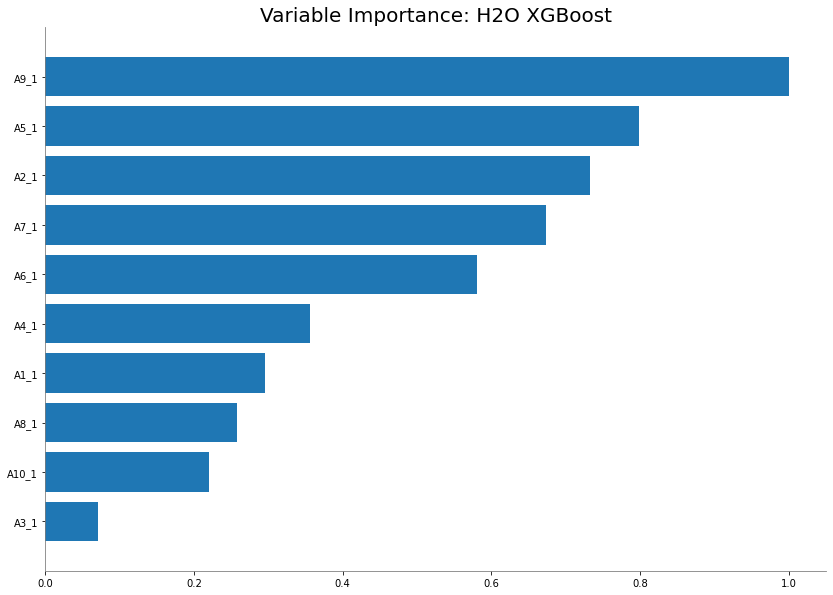

In [36]:
xgb_model.varimp_plot()